In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from matplotlib import cm

In [3]:
def gen_pattern(a, b, r_spacing=3, sampling_ratio=0.1):
    M_c = int(256/2)  # center of kspace
    N_c = int(192/2)  # center of kspace
    n = math.floor(M_c/r_spacing)  # number of regions
    p_pattern = np.zeros((256, 192))
    # generate density of the pattern
    k = 0
    for r_1 in range(0, M_c, r_spacing):
        r_2 = r_1 + r_spacing
        for i in range(256):
            for j in range(192):
                if p_pattern[i, j] != 0:
                    continue
                else:
                    radius = np.sqrt((i - M_c)**2 + (j - N_c)**2)
                    if radius <  r_2 and radius >= r_1:
                        p_pattern[i, j] = np.exp(-(b*k/n)**a)
        k += 1
#     # normalize the pattern
#     xbar = np.mean(p_pattern)
#     r = sampling_ratio / xbar
#     beta = (1-sampling_ratio) / (1-xbar)
#     p_pattern = (r<=1) * p_pattern * r + (1-(r<=1)) * (1 - (1-p_pattern) * beta)
    # keep the center square for calibration
    p_pattern[M_c-13:M_c+12, N_c-13:N_c+12] = 1
    return p_pattern

0.25795100852561453

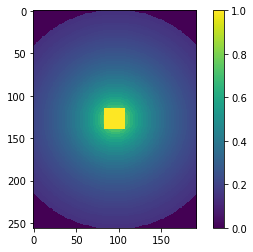

In [64]:
p_pattern = gen_pattern(a=10**(-0.124), b=10**(0.386), r_spacing=3)
plt.figure()
plt.imshow(p_pattern)
plt.colorbar()

np.mean(p_pattern)

0.1058349609375 0.11173502604166667


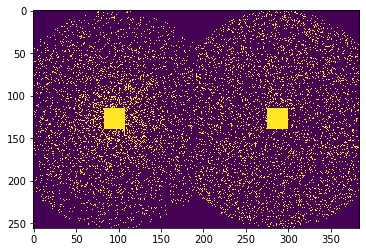

In [65]:
u = np.random.uniform(0, np.mean(p_pattern)/0.1, size=(256, 192))
mask = p_pattern>u
mask[128-13:128+12, 96-13:96+12] = 1
plt.imshow(np.concatenate((mask, mask2), axis=1))
print(np.mean(mask), np.mean(mask2))

In [49]:
u = np.random.uniform(0, 1, size=(256, 192))
mask2 = (u > 0.89) * (p_pattern > 0) 
mask2[128-13:128+12, 96-13:96+12] = 1

In [ ]:
data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

def sample_loss(params):
    print('C = {0}, gamma = {1}'.format(params[0], params[1]))
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, scoring='roc_auc', cv=3).mean()

In [ ]:
lambdas = np.linspace(1, -4, 25)
gammas = np.linspace(1, -4, 20)

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

# real_loss = [sample_loss(params) for params in param_grid]
real_loss = np.load('real_loss.npy')
# np.save('real_loss.npy', real_loss)

# The maximum is at:
param_grid[np.array(real_loss).argmax(), :]

In [ ]:
C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape), cmap=cm.jet)
plt.colorbar(cp)
plt.title('Filled contours plot of loss function L(gamma, C)')
plt.xlabel('C')
plt.ylabel('gamma')
# plt.savefig('/Users/thomashuijskens/Personal/gp-optimisation/figures/real_loss_contour.png', bbox_inches='tight')
plt.show()

In [ ]:
bounds = np.array([[-4, 1], [-4, 1]])

xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=False)

In [ ]:
plot_iteration(lambdas, xp, yp, first_iter=3, second_param_grid=gammas, optimum=[0.375, -2.15789474])